In [1]:
import jax
import jax.numpy as jnp
import numpy as np
from fbpinns.util.logger import logger
from fbpinns.domains import RectangularDomainND
from fbpinns.problems import Problem
from fbpinns.decompositions import RectangularDecompositionND
from fbpinns.networks import FCN,AdaptiveFCN,FourierFCN
from fbpinns import networks
from fbpinns.constants import Constants, get_subdomain_ws
from fbpinns.trainers import FBPINNTrainer, PINNTrainer,PINN_model_jit,FBPINN_model_jit,get_inputs
from fbpinns.traditional_solutions.seismic_cpml.seismic_CPML_2D_pressure_second_order import seismicCPML2D
from fbpinns.traditional_solutions.seismic_cpml.seismic_simulation_2dsrc import run_seismic_simulation_src
import time
import matplotlib.pyplot as plt
from fbpinns.traditional_solutions.seismic_cpml.seismic_CPML_helper import get_dampening_profiles
import jax.numpy as jnp
import pickle
from fbpinns.util.other import DictToObj
from fbpinns.analysis import load_model
from fbpinns.analysis import FBPINN_solution as FBPINN_solution_
from fbpinns.analysis import PINN_solution as PINN_solution_

In [2]:
class WaveEquation3D(Problem):
    """Solves the time-dependent (2+1)D wave equation with constant velocity
        d^2 u   d^2 u    1  d^2 u
        ----- + ----- - --- ----- = s(x,y,t)
        dx^2    dy^2    c^2 dt^2

        Boundary conditions:
        u(x,y,0) = 0
        du
        --(x,y,0) = 0
        dt
    """

    @staticmethod
    def init_params(c0=1,c1=3, sd=0.04,source=np.array([[-0.5,-0.3,0.1,1.0]])):

        static_params = {
            "dims":(1,3),
            "c0":c0,
            "c1":c1,
            "c_fn":WaveEquation3D.c_fn,
            "source":jnp.array(source),
            "sd":sd,
            }
        return static_params, {}

    @staticmethod
    def c_fn(all_params, x_batch):
        "Computes the velocity model"
    
        p = all_params["static"]["problem"]
        c0, c1 = p["c0"], p["c1"]
    
        x = x_batch[:,0:1]
        c = c0 + (c1-c0)*(1+jnp.tanh(x/0.1))/2
       
        return c

    @staticmethod
    def c_fn2(all_params,x_batch):
     
         
        x, y = x_batch[:,0:1], x_batch[:,1:2] 
    
        # Define velocity parameters (in km/s)
        v1, v2, v3 = 1.5, 2.5, 3.5  # Baseline velocities (km/s)
        A1, A2, A3 = 0.2, 0.15, 0.1  # Amplitudes of velocity variations (km/s)
        k1, k2, k3 = 2 * jnp.pi / 2, 2 * jnp.pi / 3, 2 * jnp.pi / 4  # Adjusted wavenumbers
        phi1, phi2, phi3 = 0, jnp.pi / 4, jnp.pi / 2  # Phase shifts
    
        # Define wavy layer boundaries
        z1 = 0.0 + 0.5 * jnp.sin(k1 * y + k1 * x + phi1)  # Wavy boundary for z1
        z2 = 0.5 + 0.5 * jnp.sin(k2 * y + k2 * x + phi2)  # Wavy boundary for z2
    
        # Compute velocity based on the layer
        velocity = jnp.where(x < z1, 
                            v1 + A1 * jnp.sin(k1 * y + k1 * x + phi1 ),  # Layer 1
                            jnp.where(x < z2, 
                                     v2 + A2 * jnp.sin(k2 * y + k2 * x + phi2  ),  # Layer 2
                                     v3 + A3 * jnp.sin(k3 * y + k3 * x + phi3 )))  # Layer 3
        

        velocity = velocity.flatten()
        
        velocity = iterative_gaussian_smoothing(velocity, 10, 10)  # Perform smoothing
        
                
        return velocity
 


    @staticmethod
    def sample_constraints(all_params, domain, key, sampler, batch_shapes):

        # physics loss
        x_batch_phys = domain.sample_interior(all_params, key, sampler, batch_shapes[0])
        required_ujs_phys = (
            (0,(0,0)),
            (0,(1,1)),
            (0,(2,2)),
        )
        return [[x_batch_phys, required_ujs_phys],]
        return s

    @staticmethod
    def constraining_fn(all_params, x_batch, u):
        c0 = all_params["static"]["problem"]["c0"]
        sd = all_params["static"]["problem"]["sd"]
        t = x_batch[:,2:3]

        u = (jax.nn.tanh(c0*t/(2*sd))**2)*u# constrains u(x,y,0) = u_t(x,y,0) = 0
        return u

    @staticmethod
    def loss_fn(all_params, constraints):
        params = all_params["static"]["problem"]
        c0, source = params["c0"], params["source"]
        c_fn = params["c_fn"]
        sd = all_params["static"]["problem"]["sd"]
        x_batch, uxx, uyy, utt = constraints[0]
        x, y, t = x_batch[:,0:1], x_batch[:,1:2], x_batch[:,2:3]
        
        sd = 0.04
             
         
    
        #x, t = x_batch[:,0:2], x_batch[:,2:3]
        tanh, exp = jax.nn.tanh, jnp.exp
        
        # get starting wavefield
        #p = jnp.expand_dims(source, axis=1)# (k, 1, 4)
        #x = jnp.expand_dims(x, axis=0)# (1, n, 2)
        #f1 = (p[:,:,3:4]*exp(-0.5 * ((x-p[:,:,0:2])**2).sum(2, keepdims=True)/(p[:,:,2:3]**2))).sum(0)# (n, 1)
        
        #t1 = source[:,2].min()/c0
        #f2 = exp(-0.5*(1.5*t/t1)**2) * f1


  
        e = -0.5*((x+0.7)**2 + (y)**2 + t**2)/(sd**2)
        s = 2e3*(1+e)*jnp.exp(e)# ricker source term
        #c,_,_ = extract_from_npz(npz_path, nx=80, ny=80, nt=80, for_pinn=True)
        
        c = resample_velocity_field('./marmousi_combined.npz', 80, 80,80).flatten().reshape(-1,1)
         
        c     =  jnp.array(c) 
         
        
        
        
        
        #phys = (uxx + uyy) - (1/c_fn(all_params, x_batch)**2)*utt - s
        phys = (uxx + uyy) - (1/c**2)*utt- s
        
        return jnp.mean(phys**2)
     
    @staticmethod
    def exact_solution1(all_params, x_batch, batch_shape):
        key = jax.random.PRNGKey(0)
        return jax.random.normal(key, (x_batch.shape[0],1))


    @staticmethod
    def exact_solution(all_params, x_batch, batch_shape):

        # use the seismicCPML2D FD code with very fine sampling to compute solution

        params = all_params["static"]["problem"]
        c0, source = params["c0"], params["source"]
        c_fn = params["c_fn"]
        sd = all_params["static"]["problem"]["sd"]
        (xmin, ymin, tmin), (xmax, ymax, tmax) = np.array(x_batch.min(0)), np.array(x_batch.max(0))

        # get grid spacing
        deltax, deltay, deltat = (xmax-xmin)/(batch_shape[0]-1), (ymax-ymin)/(batch_shape[1]-1), (tmax-tmin)/(batch_shape[2]-1)

        # get f0, target deltas of FD simulation
        f0 = c0/source[:,2].min()# approximate frequency of wave
        DELTAX = DELTAY = 1/(f0*20)# target fine sampled deltas
        DELTAT = DELTAX / (4*np.sqrt(2)*1.5)# target fine sampled deltas
        dx, dy, dt = int(np.ceil(deltax/DELTAX)), int(np.ceil(deltay/DELTAY)), int(np.ceil(deltat/DELTAT))# make sure deltas are a multiple of test deltas
        DELTAX, DELTAY, DELTAT = deltax/dx, deltay/dy, deltat/dt
        NX, NY, NSTEPS = batch_shape[0]*dx-(dx-1), batch_shape[1]*dy-(dy-1), batch_shape[2]*dt-(dt-1)

        # get starting wavefield
        xx,yy = np.meshgrid(np.linspace(xmin, xmax, NX), np.linspace(ymin, ymax, NY), indexing="ij")# (NX, NY)
        x = np.stack([xx.ravel(), yy.ravel()], axis=1)# (n, 2)
        exp = np.exp
        p = np.expand_dims(source, axis=1)# (k, 1, 4)
        x = np.expand_dims(x, axis=0)# (1, n, 2)
        f = (p[:,:,3:4]*exp(-0.5 * ((x-p[:,:,0:2])**2).sum(2, keepdims=True)/(sd**2))).sum(0)# (n, 1)
        p0 = f.reshape((NX, NY))
        p0_ = f.reshape((NX,NY))*0

          # get velocity model
        x = np.stack([xx.ravel(), yy.ravel()], axis=1)# (n, 2)
        c = np.array(c_fn(all_params, x))
        if c.shape[0]>1: c = c.reshape((NX, NY))
        else: c = c*np.ones_like(xx)
 
        
                # get starting wavefield
        xx,yy,tt = np.meshgrid(np.linspace(xmin, xmax, NX), np.linspace(ymin, ymax, NY),np.linspace(tmin,tmax,NSTEPS), indexing="ij")# (NX, NY)
        xdbatch = np.stack([xx.ravel(), yy.ravel(),tt.ravel()], axis=1)# (n, 2)
        exp = np.exp
        
        x,y,t = xdbatch[:,0:1],xdbatch[:,1:2],xdbatch[:,2:3]
        #x = np.expand_dims(x, axis=0)# (1, n, 2)
        #f = (p[:,:,3:4]*exp(-0.5 * ((x-p[:,:,0:2])**2).sum(2, keepdims=True)/(p[:,:,2:3]**2))).sum(0)# (n, 1)
        #t1 = source[:,2].min()/c0
        #ff = 1000*exp(-0.5*(1.5*t/t1)**2) * f
        sd = 0.04
        e = -0.5*((x+0.7)**2 + (y)**2 + t**2)/(sd**2)
        s = 2e3*(1+e)*jnp.exp(e)# ricker source term
         
         
        ff = s.reshape(NX,NY,NSTEPS)
        src = np.moveaxis(ff,-1,0) 
        density = 1.0 * np.ones((NX, NY))


        #MarmousI smooth Velocity model
        #vel,_,_= extract_from_npz(npz_path, nx=NX, ny=NY, for_pinn=False)
        vel = resample_velocity_field('./vmodel8.npy', NX, NY)/1000
      
        # add padded CPML boundary
        NPOINTS_PML = 10
        p0_ = np.pad(p0_, [(NPOINTS_PML,NPOINTS_PML),(NPOINTS_PML,NPOINTS_PML)], mode="edge")
        
        
        
        c =   np.pad(vel, [(NPOINTS_PML,NPOINTS_PML),(NPOINTS_PML,NPOINTS_PML)], mode="edge")
        density =  np.pad(density, [(NPOINTS_PML,NPOINTS_PML),(NPOINTS_PML,NPOINTS_PML)], mode="edge")
        source_array =  np.pad(src, [(0, 0), (NPOINTS_PML,NPOINTS_PML), (NPOINTS_PML, NPOINTS_PML)], mode='edge')
        # run simulation
        logger.info(f'Running seismicCPML2D {(NX, NY, NSTEPS)}..')
        
        wavefields,_ = run_seismic_simulation_src(
        NX+2*NPOINTS_PML, NY+2*NPOINTS_PML, NSTEPS, DELTAX, DELTAY, DELTAT, NPOINTS_PML,
        c, np.ones((NX+2*NPOINTS_PML,NY+2*NPOINTS_PML)), (p0_.copy(),p0_.copy()), dtype=np.float32,
        save_wavefields=True, gather_points=None, source=source_array)
        
        #normalize
        #wavefields = (wavefields - np.min(wavefields)) / (np.max(wavefields) - np.min(wavefields))
        # get croped, decimated, flattened wavefields
        wavefields = wavefields[:,NPOINTS_PML:-NPOINTS_PML,NPOINTS_PML:-NPOINTS_PML]
        wavefields = wavefields[::dt, ::dx, ::dy]
        wavefields = np.moveaxis(wavefields, 0, -1)
        assert wavefields.shape == batch_shape
        u = wavefields.reshape((-1, 1))
         
         
        return u



In [3]:

subdomain_xs = [np.linspace(-1,1,4), np.linspace(-1,1,4), np.linspace(0,1,4)]
subdomain_ws = get_subdomain_ws(subdomain_xs, 1.9)
xd = len(subdomain_xs)
c = Constants(
    run="test",
    domain=RectangularDomainND,
    domain_init_kwargs=dict(
        xmin=np.array([-1,-1,0]),
        xmax=np.array([1,1,1]),
    ),
    problem=WaveEquation3D,
    problem_init_kwargs=dict(
        c0=1,c1=3, sd=0.02,
    ),
    decomposition=RectangularDecompositionND,
    decomposition_init_kwargs=dict(
        subdomain_xs=subdomain_xs,
        subdomain_ws=subdomain_ws,
        unnorm=(0.,1.),
    ),
    network= FourierFCN,
    network_init_kwargs=dict(
        layer_sizes=[3,32,16,1],
        
    ),
    #scheduler = PointSchedulerRectangularND,
    #scheduler_kwargs = dict(
     #   point = [-1,-1,0], ),
    ns=((80,80,80),),
    n_test=(60,60,10),
    n_steps= 120000,
    optimiser_kwargs=dict(learning_rate=1e-3),
    summary_freq=1000,
    test_freq=200,
    show_figures=True,
    clear_output=True,
)


#c["network_init_kwargs"] = dict(layer_sizes=[3,64,64,64,1],mu= 0,sd=1,n_features=200) #Activate this for Fourier
#c["network_init_kwargs"] = dict(layer_sizes=[3,64,64,64,1]) #activate this for PINN


In [ ]:
run = PINNTrainer(c)
all_params,loss_log,x_batch_test,model_fns = run.train()
np.save("/home/bharath/Desktop/tfb/loss_pinn_src",loss_log)

In [ ]:
run = FBPINNTrainer(c)
all_params1,loss_log1,x_batch_test1,model_fns1= run.train()
np.save("/home/bharath/Desktop/tfb/loss_fbpinn_src",loss_log1)

In [ ]:
plt.plot(loss_log,label='PINNs')
 

#plt.plot(loss_log1,label='fbpinns_new')
plt.yscale('log')
plt.legend()

# Testing Ground

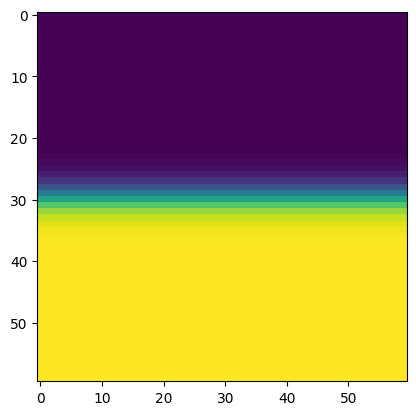

In [4]:


problem = WaveEquation3D
kwargs = dict(sd=0.04)
ps_ = problem.init_params(**kwargs)
all_params = {"static":{"problem":ps_[0]}, "trainable":{"problem":ps_[1]}}
batch_shape = (60,60,10)
x_batch = RectangularDomainND._rectangle_samplerND(None, "grid", np.array([-1, -1, 0]), 
                                                   np.array([1, 1, 1]), batch_shape)
plt.figure()
c_ = np.array(problem.c_fn(all_params, x_batch))
c_= c_.reshape(batch_shape)
plt.imshow(c_[:,:,0])


### MOdel loading and inferences

In [1]:
import jax.numpy as jnp
import pickle
from fbpinns.util.other import DictToObj
from fbpinns.analysis import load_model
from fbpinns.analysis import FBPINN_solution as FBPINN_solution_
from fbpinns.analysis import PINN_solution as PINN_solution_

#### Loading and inferences of a PINN model

In [ ]:
with open("./results_marm_pinn/summaries/test/constants_test.pickle", "rb") as f:
    c_dict = pickle.load(f)
    c = DictToObj(**c_dict, copy=True)

with open('./results_marm_pinn//models/test/model_00120000.jax', "rb") as f:
    model = pickle.load(f)

# convert np arrays to jax
model = jax.tree_util.tree_map(lambda x: jnp.array(x) if isinstance(x, np.ndarray) else x, model)

i, all_params,all_opt_states, u_test_losses = model

domain, problem, network = c.domain, c.problem, c.network

# define unnorm function
mu_, sd_ = c.decomposition_init_kwargs["unnorm"]
unnorm_fn = lambda u: networks.unnorm(mu_, sd_, u)

model_fns = (domain.norm_fn, network.network_fn, unnorm_fn, problem.constraining_fn)

u_test1, *_ = PINN_model_jit(all_params, x_batch, model_fns)
pinn = u_test1.reshape(60,60,10)

#### Loading and inferences of a Fourier Model


In [ ]:
with open("./results_marm_fourier//summaries/test/constants_test.pickle", "rb") as f:
    c_dict = pickle.load(f)
    c = DictToObj(**c_dict, copy=True)

with open('./results_marm_fourier//models/test/model_00120000.jax', "rb") as f:
    model = pickle.load(f)

# convert np arrays to jax
model = jax.tree_util.tree_map(lambda x: jnp.array(x) if isinstance(x, np.ndarray) else x, model)

i, all_params,all_opt_states, u_test_losses = model

domain, problem, network = c.domain, c.problem, c.network

# define unnorm function
mu_, sd_ = c.decomposition_init_kwargs["unnorm"]
unnorm_fn = lambda u: networks.unnorm(mu_, sd_, u)

model_fns = (domain.norm_fn, network.network_fn, unnorm_fn, problem.constraining_fn)

u_testf, *_ = PINN_model_jit(all_params, x_batch, model_fns)
fourier = u_testf.reshape(60,60,10)

#### Loading and Inferences of a FBPINN Model


In [ ]:
with open("./results_marm_fbpinn//summaries/test/constants_test.pickle", "rb") as f:
    c_dict = pickle.load(f)
    c = DictToObj(**c_dict, copy=True)
    
with open('./results_marm_fbpinn//models/test/model_00120000.jax', "rb") as f:
    model = pickle.load(f)

# convert np arrays to jax
model = jax.tree_util.tree_map(lambda x: jnp.array(x) if isinstance(x, np.ndarray) else x, model)
i, all_params, all_opt_states, active, u_test_losses = model

problem, decomposition, network = c.problem, c.decomposition, c.network

model_fns = (decomposition.norm_fn, network.network_fn, decomposition.unnorm_fn, decomposition.window_fn, problem.constraining_fn)

takes, _, (_, _, _, cut_all, _) = get_inputs(x_batch, active, all_params, c.decomposition)

all_params_cut = {"static":cut_all(all_params["static"]),
                  "trainable":cut_all(all_params["trainable"])}

u_test2_n2,*_ = FBPINN_model_jit(all_params_cut, x_batch, takes, model_fns)
 
fbpinn=u_test2_n2.reshape(60,60,10)

#### plotting output and residuals

In [ ]:
import matplotlib.pyplot as plt

def plot_seismic_slices_extended(
    u_testFCN, u_fbPINN, u_fourier, u, vel_model,
    interpolation='none', cmap='viridis', save_path=None, dpi=600
):
    """
    Function to create subplots showing specific timesteps from the provided arrays.
    """
    slices = [1, 3, 4]  # Indices for timesteps to plot
    num_slices = len(slices)
    time_steps = [round(i * (1 / 10), 2) for i in slices]  # Calculate time values for slices

    # Create subplots with 7 rows and num_slices columns
    fig, axs = plt.subplots(7, num_slices, figsize=(10, 20), sharex=True, sharey=True)

    # Order of data for plotting
    plot_order = [
        ("FDM", u),
        ("PINN", u_testFCN),
        ("FDM - PINN", u_testFCN - u),
        ("FBPINN", u_fbPINN),
        ("FDM - FBPINN", u_fbPINN - u),
        ("Fourier", u_fourier),
        ("FDM - Fourier", u_fourier - u ),
    ]

    for row, (title, data) in enumerate(plot_order):  # Iterate through rows and data
        for col, slice_idx in enumerate(slices):  # Iterate through selected slices
            im = axs[row, col].imshow(vel_model, cmap='gray', alpha=0.5, interpolation=interpolation)
            im_sol = axs[row, col].imshow(
                data[:, :, slice_idx],
                cmap=cmap, alpha=0.8 if "-" in title else 0.6, interpolation=interpolation
            )
            axs[row, col].set_title(f"{title} ({time_steps[col]} s)", fontsize=10)
            plt.colorbar(im_sol, ax=axs[row, col])

    # Set axis labels
    for ax in axs[:, 0]:
        ax.set_ylabel("Z (km)", fontsize=12)
        ax.set_yticks([0, vel_model.shape[0] // 2, vel_model.shape[0] - 1])
        ax.set_yticklabels([0, 1, 2])  # Convert grid to kilometers
    for ax in axs[-1, :]:
        ax.set_xlabel("X (km)", fontsize=12)
        ax.set_xticks([0, vel_model.shape[1] // 2, vel_model.shape[1] - 1])
        ax.set_xticklabels([0, 1, 2])  # Convert grid to kilometers

    # Adjust layout for better appearance
    plt.tight_layout(rect=[0, 0, 0.9, 1])

    # Save the figure if a path is provided
    if save_path:
        plt.savefig(save_path, format='png', dpi=dpi, bbox_inches='tight')

    # Show the figure
    plt.show()


#### Auxiliary Functions


#### smoothing function


In [2]:
from scipy.ndimage import gaussian_filter
import numpy as np

def iterative_gaussian_smoothing(velocity, sigma=1, iterations=5):
    """
    Iteratively applies Gaussian smoothing to a 2D velocity field.

    Parameters:
        velocity (np.ndarray): The original 2D velocity field.
        sigma (float): Standard deviation for the Gaussian kernel.
        iterations (int): Number of times to apply the smoothing.

    Returns:
        np.ndarray: Smoothed velocity field after the specified number of iterations.
    """
    smoothed_velocity = velocity.copy()
    for i in range(iterations):
        smoothed_velocity = gaussian_filter(smoothed_velocity, sigma=sigma)
    return smoothed_velocity

#### Resample velocity

In [ ]:
import numpy as np
from scipy.interpolate import RectBivariateSpline

def resample_velocity_field(file_path, nx, ny, nt=None):
    """
    Resamples a velocity field from an .npy or .npz file to the specified dimensions.
    
    Parameters:
        file_path (str): Path to the .npy or .npz file containing the velocity field.
        nx (int): Number of grid points in the X dimension.
        ny (int): Number of grid points in the Y dimension.
        nt (int, optional): Number of copies to stack along a new dimension. If None, returns a 2D array.
    
    Returns:
        resampled_velocity (np.ndarray): Resampled velocity field (nx x ny) or (nx x ny x nt).
    """
    # Load the velocity model based on the file extension
    if file_path.endswith('.npz'):
        velocity_model = np.load(file_path)['velocity']  # Load 'velocity' key for .npz files
    else:  # Assume .npy
        velocity_model = np.load(file_path)
    
    # Optional: Apply smoothing if needed
    velocity_model = iterative_gaussian_smoothing(velocity_model, 4, 10)
    
    # Original grid for the velocity model
    original_x = np.linspace(0, 1, velocity_model.shape[1])
    original_y = np.linspace(0, 1, velocity_model.shape[0])
    
    # Interpolator
    interpolator = RectBivariateSpline(original_y, original_x, velocity_model)
    
    # Define target grids
    target_x = np.linspace(0, 1, nx)
    target_y = np.linspace(0, 1, ny)
    
    # Resample to nx x ny
    resampled_velocity_2d = interpolator(target_y, target_x)
    
    # If nt is specified, stack along a new dimension
    if nt is not None:
        resampled_velocity = np.stack([resampled_velocity_2d] * nt, axis=2)
    else:
        resampled_velocity = resampled_velocity_2d
    
    return resampled_velocity

# Example usage
fdmv = resample_velocity_field('./vmodel8.npy', 60, 60)  # Resample to 60x60
pinnv = resample_velocity_field('./vmodel8.npy', 80, 80, 80).flatten().reshape(-1, 1)  # Resample to 80x80x80 and flatten
